In [37]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector

In [29]:
# CUSUM Tuning
cusum_thresholds = np.arange(2, 20, 0.5)
cusum_bs = np.arange(1, 13, 0.5)
best_f1 = float("-inf")
best_thres = 0
best_b = 0
for thres in cusum_thresholds:
    for cusum_b in cusum_bs:
        env = HillClimbingCar()

        run_tracker = env.run_control_system(   
                config={
                        "params": {
                            "m": 1200,       # Mass (kg)
                            "g": 9.81,       # Gravity (m/s^2)
                            "Cr": 0.01,      # Rolling resistance coefficient
                            "Cd": 0.3,       # Aerodynamic drag coefficient
                            "A": 2.2,        # Frontal area (m^2)
                            "rho": 1.225,    # Air density (kg/m^3)
                            "Fmax": 40000,    # Maximum engine force (N)
                        },
                        "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                        "dt": 0.1,
                        "time": 500,
                        "attack-start": 10,
                        "attack-end": 20,
                        "v-controller": PIDController(0.5, 0.5, 0.01),
                        "target-velocity": 20,
                        "process-noise-cov": np.diag([0.01, 0.1]),
                        "measurement-noise-cov": 0.2,
                        "anomaly-detector": CUSUMDetector(
                            thresholds=thres*np.array([0.16000361755278]),
                            b=np.array([0.18543593999687008]) + cusum_b*np.array([0.16000361755278])),
                    },
                show_plots=False
            )

        time = np.arange(0, 500, 0.1)
        attack_labels = [(x >= 10 and x <= 20) for x in time]
        attack_predictions = run_tracker.get_metrics(metric="attack_predictions")
        cm = confusion_matrix(attack_predictions, attack_predictions)
        prec = precision_score(attack_labels, attack_predictions)
        rec = recall_score(attack_labels, attack_predictions)
        acc = accuracy_score(attack_labels, attack_predictions)
        f1 = f1_score(attack_labels, attack_predictions)
        if f1 > best_f1:
            best_thres = thres
            best_b = cusum_b
            best_f1 = f1
            best_acc = acc
            best_rec = rec
            best_prec = prec
    print(f"-----------------\nParams: {best_thres, best_b}\nAccuracy: {best_acc}\nPrecision: {best_prec}\nRecall: {best_rec}")





/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:

-----------------
Params: (10.5, 7.5)
Accuracy: 0.999
Precision: 0.9897959183673469
Recall: 0.9603960396039604


In [59]:
# MSE
mmsce2 = []
for mag in range(1, 10):
    msce = []
    for _ in range(100):
        env = HillClimbingCar()
        run_tracker = env.run_control_system(   
            config={
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.1,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": mag,
                    "v-controller": PIDController(0.5, 0.5, 0.01),
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.01, 0.1]),
                    "measurement-noise-cov": 0.2,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=10.5*np.array([0.16000361755278]),
                        b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
                },
            show_plots=False
        )
        msce.append(np.mean(run_tracker.ms_control_error()))
    mmsce2.append(msce)


In [55]:
np.mean(msce), np.std(msce)

(6.945416828981613, 1.5582852595428953)

In [60]:
mmsce

[[1.2394993530961018,
  0.716866138378243,
  1.1581001396330879,
  1.1389033716844101,
  1.0945523267092965,
  1.7091209689987186,
  0.706034109934616,
  3.4828932197553297,
  0.7344541354703757,
  6.311446339175192,
  2.54567317878616,
  1.0535296626612074,
  1.8066019725535976,
  1.3755983297873395,
  1.1057262937590928,
  2.881783302155693,
  1.4976330250388534,
  0.7558491138881993,
  6.060332259576027,
  3.997509315922697,
  5.962353706069826,
  0.7004465416496831,
  0.8282993775018788,
  0.9483777670833048,
  1.1497341932706537,
  6.541297413143342,
  1.6139683762919166,
  5.137223028486922,
  2.218280187335575,
  2.409805344608582,
  3.938866757738063,
  6.369770293690431,
  1.1764569069653537,
  1.5695516908387863,
  1.438501917056007,
  7.624018800746597,
  14.960414406451992,
  1.8759742672216437,
  1.0286292609757757,
  2.4498358705841037,
  1.6742153115835692,
  3.2977135958103525,
  0.7715838604345964,
  1.590671280377795,
  3.4219876318813736,
  2.130609104344831,
  2.475

In [61]:
mmsce2

[[1.5251730983538587,
  2.1582316307355347,
  5.007142021239392,
  3.6561127155290154,
  2.9172005080130834,
  0.8416749831022722,
  1.9383284038341022,
  6.42452664311261,
  1.223095026554377,
  3.1573774291053285,
  2.341583516456729,
  1.657607064800578,
  2.1488891994528045,
  7.218700789020254,
  0.8782201954205016,
  1.3205303742761794,
  0.6992833752095161,
  1.9745663972816805,
  1.4835476709766857,
  0.9132654789292409,
  2.618703745312464,
  10.894040518286682,
  0.5299272252342319,
  1.6613053160726925,
  6.760011163264392,
  2.4490572980596834,
  0.6675312552638144,
  6.3960449922808005,
  0.9079793649425546,
  1.0675875281791793,
  1.4202443638319577,
  5.54011070800346,
  1.2827251306533975,
  4.480590951983375,
  17.269447112547283,
  11.235723799333984,
  1.8590750002474126,
  17.17600049209218,
  1.09416955712739,
  29.744775263561344,
  1.2016916867263923,
  8.015605455655335,
  4.235536469712787,
  0.8669386727329991,
  3.254980349305943,
  2.908568947025157,
  7.768

In [62]:
stats_base = [(np.mean(x), np.std(x)) for x in mmsce]
stats_ekf = [(np.mean(x), np.std(x)) for x in mmsce2]

In [63]:
stats_base

[(2.832507781423014, 2.731966852696139),
 (2.906980539729489, 2.3189911477739122),
 (3.974419222679005, 2.8821740646782383),
 (5.537558540264455, 2.6694691515266897),
 (6.988408049771854, 2.927412225644281),
 (9.073915296944083, 1.6407056926518482),
 (12.315243616441679, 2.469814534505944),
 (15.5058404754815, 2.0476267257742724),
 (20.36054567598587, 2.653298301283018)]

In [64]:
stats_ekf

[(4.291068675995974, 4.583600381541723),
 (5.493661806515961, 7.155542485222117),
 (4.293363980709232, 5.160414171290278),
 (4.44336095821563, 4.470654243522835),
 (5.201131238377831, 5.4657732726985655),
 (5.792390113324972, 7.833562170562348),
 (5.529581769538132, 3.9235456914677393),
 (6.270337314794597, 3.901243670583415),
 (7.22152837068931, 4.075659918571724)]

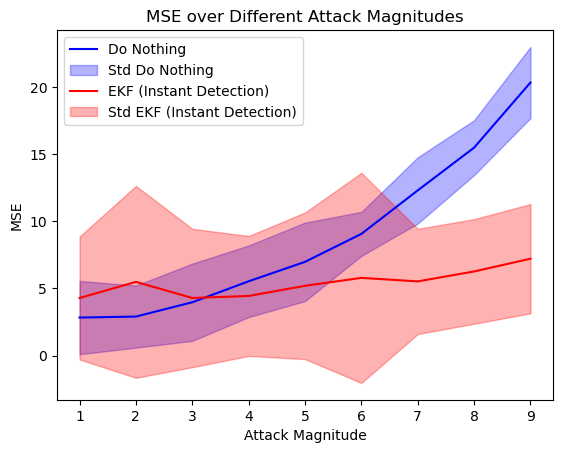

In [68]:
plt.plot(range(1, 10), [x[0] for x in stats_base], color="blue", label="Do Nothing")
plt.fill_between(range(1, 10), [-x[1]+x[0] for x in stats_base], [x[1] + x[0] for x in stats_base], color="blue", alpha=0.3, label="Std Do Nothing")
plt.plot(range(1, 10), [x[0] for x in stats_ekf], color="red", label="EKF (Instant Detection)")
plt.fill_between(range(1, 10), [-x[1] + x[0] for x in stats_ekf], [x[1] + x[0] for x in stats_ekf], color="red", alpha=0.3, label="Std EKF (Instant Detection)")
plt.title("MSE over Different Attack Magnitudes")
plt.xlabel("Attack Magnitude")
plt.ylabel("MSE")
plt.legend()
plt.show()

### PID-Tuning CarHillclimber

In [79]:


def pid_loss_fn(theta):
    Kp, Ki, Kd = theta
    env = HillClimbingCar()
    init_speed = 30*np.random.rand()

    tracker = env.run_control_system(
        config={
            "params": {
                "m": 1200,       # Mass (kg)
                "g": 9.81,       # Gravity (m/s^2)
                "Cr": 0.01,      # Rolling resistance coefficient
                "Cd": 0.3,       # Aerodynamic drag coefficient
                "A": 2.2,        # Frontal area (m^2)
                "rho": 1.225,    # Air density (kg/m^3)
                "Fmax": 40000,    # Maximum engine force (N)
            },
            "init-state": np.array([0, init_speed]),  # [Position (m), Velocity (m/s)]
            "dt": 0.1,
            "time": 50,
            "attack-start": -10,
            "attack-end": -20,
            "attack-magnitude": 0.0,
            "v-controller": PIDController(Kp, Ki, Kd),
            "target-velocity": 20,
            "process-noise-cov": np.diag([0.01, 0.1]),
            "measurement-noise-cov": 0.2,
            "anomaly-detector": CUSUMDetector(
                thresholds=10.5*np.array([0.16000361755278]),
                b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
        },
        show_plots=False
    )

    loss = 0.1*tracker.ms_control_error().sum() / 50
    return loss

def compute_gradient(theta, delta):

    loss = pid_loss_fn(theta + delta*np.array([1,0,0]))
    dKp = (loss - pid_loss_fn(theta-delta*np.array([1,0,0]))) / (2*delta)
    dKi = (pid_loss_fn(theta + delta*np.array([0,1,0])) - pid_loss_fn(theta-delta*np.array([0,1,0]))) / (2*delta)
    dKd = (pid_loss_fn(theta + delta*np.array([0,0,1])) - pid_loss_fn(theta-delta*np.array([0,0,1]))) / (2*delta)

    return np.array([dKp, dKi, dKd]), loss


Loss at Step 0: 3.0037719533577474
Loss at Step 10: 2.927474337379327
Loss at Step 20: 2.9633476495605144
Loss at Step 30: 7.155367970599867
Loss at Step 40: 1.7771367539715197
Loss at Step 50: 2.3698208923820676
Loss at Step 60: 2.938858163643798
Loss at Step 70: 3.3950813005328566
Loss at Step 80: 6.849204407188466
Loss at Step 90: 4.208755873660497
Loss at Step 100: 7.243096497025303
Loss at Step 110: 3.7786366038266
Loss at Step 120: 2.3007914752876535
Loss at Step 130: 3.525039961031973
Loss at Step 140: 5.748587354761313
Loss at Step 150: 2.012506227575544
Loss at Step 160: 0.9018418275447868
Loss at Step 170: 2.224566112711632
Loss at Step 180: 4.2188847354054335
Loss at Step 190: 2.4068731557488063
Loss at Step 200: 4.654363358683967
Loss at Step 210: 3.714806677437826
Loss at Step 220: 3.0573926532193045
Loss at Step 230: 2.546007089875316
Loss at Step 240: 1.7589758372088602
Loss at Step 250: 14.891062618170876
Loss at Step 260: 1.9286967517379288
Loss at Step 270: 1.92640728

Text(0.5, 1.0, 'PID Controller Loss Function')

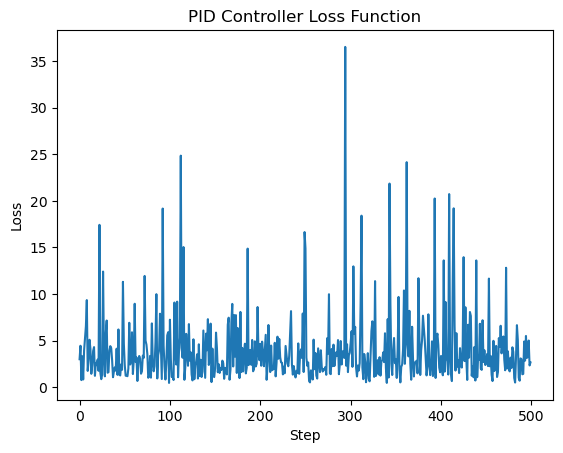

In [80]:
delta = 1e-5
theta0 = np.array([0.5, 0.5, 0.01])
lr = 1e-4
NBR_STEPS = 500


losses = []
theta = theta0
best_theta = theta0
best_loss = float("inf")
for step in range(NBR_STEPS):
    # Compute Gradient
    grad, loss = compute_gradient(theta, delta)
    grad = (1 / np.linalg.norm(grad, 2)) * grad
    
    # Gradient Descent
    theta = theta - lr*grad
    losses.append(loss)
    if loss < best_loss:
        best_theta = theta
    if step % 10 == 0:
        print(f"Loss at Step {step}: {loss}")

plt.plot(range(NBR_STEPS), losses)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("PID Controller Loss Function")


In [81]:
best_theta

array([0.50320036, 0.50027134, 0.00711447])

### Data Analysis

In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

file = f"./data/{sorted(os.listdir("./data"))[-1]}"
print(file)
df = pd.read_csv(file)
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

./data/car_data_2025-02-0612:11:39.059637.csv


In [311]:
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
0,0.00,0.000000,19.000000,0.000000,19.000000,21.114374,-0.117009,False,False
1,0.01,0.199748,18.923724,0.176234,20.036675,18.002440,0.204172,False,False
2,0.02,0.415641,18.970858,0.383711,19.052371,18.866058,0.123480,False,False
3,0.03,0.652599,18.983735,0.574960,18.978688,19.598219,0.052273,False,False
4,0.04,0.813331,19.014459,0.762813,19.296081,18.654250,0.153398,False,False


In [312]:
df['abs_est_error'] = (df.vel - df.est_vel).apply(lambda x: np.abs(x))
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,abs_est_error
0,0.00,0.000000,19.000000,0.000000,19.000000,21.114374,-0.117009,False,False,0.000000
1,0.01,0.199748,18.923724,0.176234,20.036675,18.002440,0.204172,False,False,1.112950
2,0.02,0.415641,18.970858,0.383711,19.052371,18.866058,0.123480,False,False,0.081513
3,0.03,0.652599,18.983735,0.574960,18.978688,19.598219,0.052273,False,False,0.005047
4,0.04,0.813331,19.014459,0.762813,19.296081,18.654250,0.153398,False,False,0.281622


In [313]:
df.iloc[0:20]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,abs_est_error
0,0.00,0.000000,19.000000,0.000000,19.000000,21.114374,-0.117009,False,False,0.000000
1,0.01,0.199748,18.923724,0.176234,20.036675,18.002440,0.204172,False,False,1.112950
2,0.02,0.415641,18.970858,0.383711,19.052371,18.866058,0.123480,False,False,0.081513
3,0.03,0.652599,18.983735,0.574960,18.978688,19.598219,0.052273,False,False,0.005047
4,0.04,0.813331,19.014459,0.762813,19.296081,18.654250,0.153398,False,False,0.281622
5,0.05,0.982193,19.020413,0.958025,18.999599,17.540338,0.277088,False,False,0.020813
6,0.06,1.188741,19.181357,1.153003,18.315020,18.625430,0.175451,False,False,0.866338
7,0.07,1.423047,19.232595,1.335367,18.498416,20.748515,-0.040600,False,False,0.734179
8,0.08,1.622467,19.258708,1.513297,19.615676,17.492314,0.297559,False,False,0.356968
9,0.09,1.820041,19.302486,1.716826,18.602400,19.752720,0.072755,False,False,0.700085


In [314]:
df.describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,abs_est_error
count,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,24.9950,487.467770,19.635239,517.914222,19.273935,20.718075,0.037905,0.826336
std,14.4352,282.379291,0.616461,306.237070,1.537160,1.806712,0.114782,0.866436
min,0.0000,0.000000,17.764999,0.000000,15.504683,16.264888,-0.471650,0.000000
25%,12.4975,243.641536,19.506205,241.228668,19.039965,19.494061,-0.039443,0.239745
50%,24.9950,483.722744,19.820008,535.970629,19.790332,20.337853,0.030059,0.546102
75%,37.4925,732.568091,20.022071,786.058281,20.283275,21.489941,0.128488,1.069659
max,49.9900,981.356131,20.647842,1036.054133,22.046074,27.608688,0.459067,3.645885


In [315]:
df.iloc[1000:2000].describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,abs_est_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.995000,290.317992,18.609539,282.634588,16.467601,23.638462,0.086608,2.148107
std,2.888194,53.605398,0.552316,47.656647,0.578488,1.149493,0.080643,0.957377
min,10.000000,198.282932,17.764999,199.720571,15.504683,20.248089,-0.471650,0.214067
25%,12.497500,243.641536,18.126752,241.228668,15.961445,22.830788,0.012682,1.306463
50%,14.995000,288.901213,18.384155,283.532089,16.650141,23.602724,0.123532,1.566573
75%,17.492500,336.661201,19.130645,323.991225,16.865271,24.413508,0.153672,3.196528
max,19.990000,384.479135,19.892367,363.619214,21.910310,27.608688,0.290654,3.645885


In [316]:
df.iloc[:1000].describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,abs_est_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.995000,99.524635,19.879860,99.759043,19.974988,19.976789,0.080314,0.490399
std,2.888194,56.938244,0.318038,57.668797,0.632520,1.070561,0.131240,0.370864
min,0.000000,0.000000,18.728361,0.000000,17.777640,16.264888,-0.356160,0.000000
25%,2.497500,50.513251,19.715631,49.869255,19.534705,19.208902,-0.015508,0.193303
50%,4.995000,99.961801,19.911123,99.967652,19.993922,19.994522,0.074929,0.413013
75%,7.492500,148.657577,20.093777,149.536088,20.422356,20.721134,0.178071,0.713771
max,9.990000,198.069841,20.575730,199.605578,22.046074,23.313329,0.459067,2.059977


Precision: [0.98420533]
Recall: [0.997998]


Text(50.722222222222214, 0.5, 'Actual')

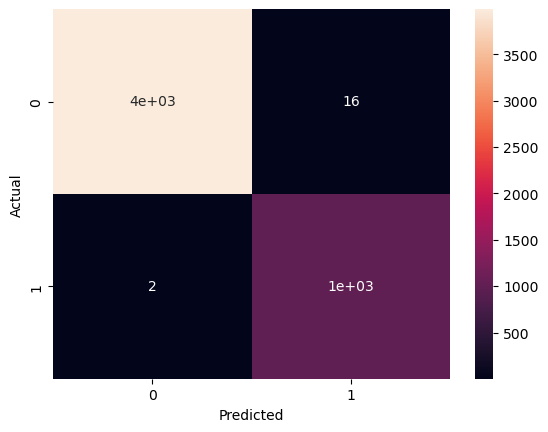

In [317]:
FP = df[(df.attack == False) & (df.attack_pred == True)][['attack']].count().values
TP = df[(df.attack == True) & (df.attack_pred == True)][['attack']].count().values
FN = df[(df.attack == True) & (df.attack_pred == False)][['attack']].count().values
TN = df[(df.attack == False) & (df.attack_pred == False)][['attack']].count().values

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
print(f"Precision: {TP / (TP+FP)}")
print(f"Recall: {TP / (TP+FN)}")
cm = confusion_matrix(df.attack, df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

<Axes: xlabel='time', ylabel='attack_pred'>

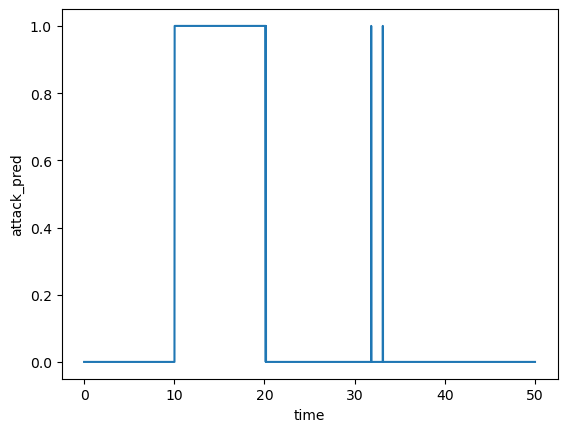

In [318]:
sns.lineplot(data=df, x='time', y='attack_pred')

<Axes: xlabel='time', ylabel='measured_vel'>

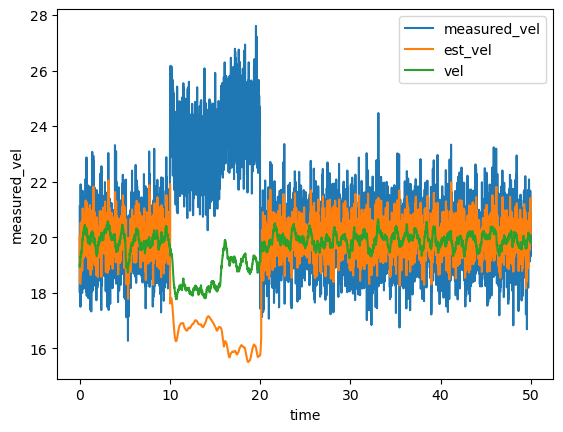

In [319]:
sns.lineplot(data=df, x='time', y='measured_vel', label="measured_vel")
sns.lineplot(data=df, x='time', y='est_vel', label="est_vel")
sns.lineplot(data=df, x='time', y='vel', label="vel")

<Axes: xlabel='time', ylabel='abs_est_error'>

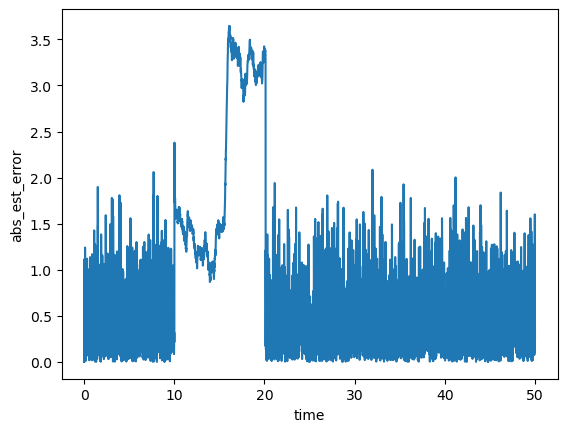

In [320]:
sns.lineplot(data=df, x='time', y='abs_est_error')

### CUSUM Tuning

In [254]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

attack_magnitudes = [3, 5]
taus = np.arange(4, 6, 0.2)
best_f1 = float('-inf')
best_b, best_tau = -1, -1

for tau in taus:
    bs = np.arange(0.4, 0.6, 0.02)
    for b in bs:
        dfs = []
        for attack_mag in attack_magnitudes:
            env = HillClimbingCar()
            logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": attack_mag,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([tau]),
                        b=np.array([b])),
                },
                show_plots=False)
            
            df = pd.DataFrame(logger.data)
            dfs.append(df)
        
        df = pd.concat(dfs)
        f1 = f1_score(df.attack, df.attack_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_b = b
            best_tau = tau


In [255]:
best_f1

0.3345332775219757

In [256]:
best_b


0.5400000000000001

In [257]:
best_tau

5.400000000000001

### Performance Evaluation

In [369]:
%reload_ext autoreload
%autoreload 2
NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(1000-i)
    attack_magnitude = np.random.rand()*4 + 3
    attack_start_time = np.random.randint(40)
    attack_length = np.random.randint(40)
    attack_end_time = min(attack_start_time + attack_length, 50)

    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": attack_start_time,
                    "attack-end": attack_end_time,
                    "attack-magnitude": attack_magnitude,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                },
                show_plots=False)
    df = pd.DataFrame(logger.data)
    df['attack_magnitude'] = attack_magnitude
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/recovery_data_cusum.csv')

CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Up

In [370]:
rec_df = pd.read_csv('./data/recovery_data.csv')
no_rec_df = pd.read_csv('./data/no_recovery_data.csv')
rec_df_c = pd.read_csv('./data/recovery_data_cusum.csv')

In [371]:
rec_df.head()

,Unnamed: 0,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,attack_magnitude
0,0,0.00,0.000000,19.000000,0.000000,19.000000,19.744324,0.026846,False,False,5.614358
1,1,0.01,0.180488,19.019068,0.185278,19.375568,19.011631,0.105057,False,False,5.614358
2,2,0.02,0.355500,19.070704,0.380330,19.209977,18.706036,0.142086,False,False,5.614358
3,3,0.03,0.567309,19.090368,0.574211,18.980564,17.994298,0.223289,False,False,5.614358
4,4,0.04,0.745375,19.156822,0.767414,18.523527,19.360015,0.089917,False,False,5.614358


In [372]:
rec_df['reference_vel'] = 20
rec_df['control_error'] = rec_df['reference_vel'] - rec_df['vel']
rec_MSE = rec_df['control_error'].map(lambda x: x*x).mean()

rec_df_c['reference_vel'] = 20
rec_df_c['control_error'] = rec_df_c['reference_vel'] - rec_df_c['vel']
rec_MSE_c = rec_df_c['control_error'].map(lambda x: x*x).mean()

no_rec_df['reference_vel'] = 20
no_rec_df['control_error'] = no_rec_df['reference_vel'] - no_rec_df['vel']
norec_MSE = no_rec_df['control_error'].map(lambda x: x*x).mean()

print(f"MSE with Recovery: {rec_MSE}")
print(f"MSE with Recovery (Standard CUSUM): {rec_MSE_c}")
print(f"MSE without Recovery: {norec_MSE}")

MSE with Recovery: 5.405004450321171
MSE with Recovery (Standard CUSUM): 4.565507802138088
MSE without Recovery: 8.250811353571818


Text(50.722222222222214, 0.5, 'Actual')

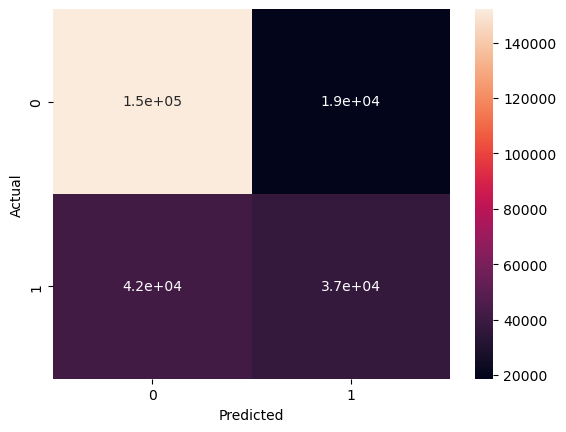

In [373]:
cm = confusion_matrix(rec_df.attack, rec_df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

In [374]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy: {accuracy_score(rec_df.attack, rec_df.attack_pred)}")
print(f"Precision: {precision_score(rec_df.attack, rec_df.attack_pred)}")
print(f"Recall: {recall_score(rec_df.attack, rec_df.attack_pred)}")

Accuracy: 0.757636
Precision: 0.6668454935622318
Recall: 0.47053034031116325


In [375]:
print(f"Accuracy: {accuracy_score(rec_df_c.attack, rec_df_c.attack_pred)}")
print(f"Precision: {precision_score(rec_df_c.attack, rec_df_c.attack_pred)}")
print(f"Recall: {recall_score(rec_df_c.attack, rec_df_c.attack_pred)}")

Accuracy: 0.684296
Precision: 0.5018214425825254
Recall: 0.5649140073942285


In [377]:
rec_df.describe()

,Unnamed: 0,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack_magnitude,reference_vel,control_error
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.000000
mean,2499.500000,24.995000,481.811914,19.021431,490.595468,19.361820,20.638563,0.036413,4.858452,20.0,0.978569
std,1443.378531,14.433785,275.821530,2.108892,283.359136,1.665963,1.899243,0.119311,1.220813,0.0,2.108892
min,0.000000,0.000000,0.000000,11.656283,0.000000,12.098382,12.510017,-0.791489,3.024078,20.0,-8.291415
25%,1249.750000,12.497500,245.319232,17.456850,247.386236,19.073343,19.424012,-0.028163,3.791052,20.0,-0.018910
50%,2499.500000,24.995000,484.238208,19.739308,489.837771,19.824821,20.289017,0.022440,4.650859,20.0,0.260692
75%,3749.250000,37.492500,715.847750,20.018910,728.270802,20.330979,21.442593,0.108442,5.990710,20.0,2.543150
max,4999.000000,49.990000,1226.470990,28.291415,1119.170757,25.493203,30.814600,0.749136,6.973266,20.0,8.343717


### Uncertainty Plot

In [410]:
%reload_ext autoreload
%autoreload 2
NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(4232+i)
    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 30,
                    "attack-magnitude": 5,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                },
                show_plots=False)
    df = pd.DataFrame(logger.data)
    df['attack_magnitude'] = attack_magnitude
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/plot_recovery_mc.csv')

Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds
Updateds


In [411]:
df1 = pd.read_csv("./data/plot_no_recovery.csv")
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1['reference_vel'] = 20
df1['control_error'] = df1['reference_vel'] - df1['vel']
df2 = pd.read_csv("./data/plot_recovery.csv")
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2['reference_vel'] = 20
df2['control_error'] = df2['reference_vel'] - df2['vel']
df3 = pd.read_csv("./data/plot_recovery_mc.csv")
df3.drop('Unnamed: 0', axis=1, inplace=True)
df3['reference_vel'] = 20
df3['control_error'] = df3['reference_vel'] - df3['vel']

In [412]:
df2[df2.attack_pred]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,attack_magnitude,reference_vel,control_error
3001,30.01,498.368778,15.022958,600.212432,19.654168,13.252036,0.075284,False,True,5.319139,20,4.977042
3002,30.02,498.485615,14.986506,600.408974,19.676980,16.772440,0.090756,False,True,5.319139,20,5.013494
3003,30.03,498.652868,15.028846,600.605743,19.704947,15.361258,0.112628,False,True,5.319139,20,4.971154
3004,30.04,498.803086,15.028768,600.802793,19.740200,13.907122,0.140866,False,True,5.319139,20,4.971232
3005,30.05,498.974687,15.086744,601.000195,19.784862,15.993901,0.157506,False,True,5.319139,20,4.913256
...,...,...,...,...,...,...,...,...,...,...,...,...
249995,49.95,1055.642676,23.647041,836.049744,15.907397,24.626419,0.003516,False,True,5.319139,20,-3.647041
249996,49.96,1055.914691,23.650305,836.208818,15.906735,24.027375,0.003911,False,True,5.319139,20,-3.650305
249997,49.97,1056.121829,23.639755,836.367885,15.906206,24.160011,0.003633,False,True,5.319139,20,-3.639755
249998,49.98,1056.293497,23.666825,836.526947,15.905583,24.699993,0.000668,False,True,5.319139,20,-3.666825


<Axes: xlabel='time', ylabel='vel'>

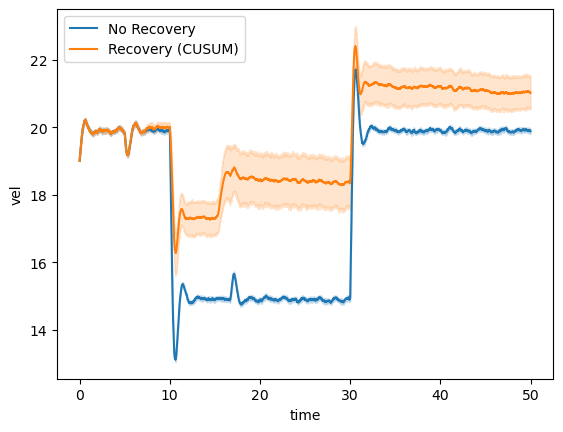

In [ ]:
sns.lineplot(data=df1, x='time', y='vel', label="No Recovery")
sns.lineplot(data=df2, x='time', y='vel', label="Recovery (CUSUM)")
sns.lineplot(data=df2, x='time', y='vel', label="Recovery (CUSUM-CLIP)")
plt.vlines(x=10, ymin=13, ymax=22, color="red")
plt.vlines(x=30, ymin=13, ymax=22, color="red")